# MALLORN TDE Classification v1.2 - Balanced LightGBM Training

**Chiến lược:** Trung gian giữa v1 (overfit) và v1.1 (underfit)

| Metric | v1  | v1.2 Target |
|--------|-----|-------------|
| CV F1 | 0.57  | ~0.60-0.65 |
| Kaggle | 0.5617 | >0.58 |
| Gap | 0.12 | <0.08 |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import joblib
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, classification_report, roc_auc_score)
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## Tải Features

In [2]:
train_features = pd.read_csv('train_features.csv')
test_features = pd.read_csv('test_features.csv')

print(f"Training samples: {len(train_features)}")
print(f"Test samples: {len(test_features)}")
print(f"TDE ratio: {train_features['target'].mean():.4f}")
print(f"Number of features: {len(train_features.columns) - 2}")

Training samples: 3043
Test samples: 7135
TDE ratio: 0.0486
Number of features: 306


## Chuẩn bị Dữ liệu

In [3]:
exclude_cols = ['object_id', 'target', 'Z_err', 'z_relative_err']
feature_cols = [c for c in train_features.columns if c not in exclude_cols]

X = train_features[feature_cols].values
y = train_features['target'].values

for col in feature_cols:
    if col not in test_features.columns:
        test_features[col] = 0

X_test = test_features[feature_cols].values

print(f"Feature matrix: {X.shape}")
print(f"Test matrix: {X_test.shape}")
print(f"Features: {len(feature_cols)}")

Feature matrix: (3043, 306)
Test matrix: (7135, 306)
Features: 306


## Scaling Features

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

print("Features scaled")

Features scaled


## Class Weights

In [5]:
n_neg = np.sum(y == 0)
n_pos = np.sum(y == 1)
scale_pos_weight = n_neg / n_pos

print(f"Class distribution:")
print(f"  Non-TDE: {n_neg} ({100*n_neg/len(y):.1f}%)")
print(f"  TDE: {n_pos} ({100*n_pos/len(y):.1f}%)")
print(f"  scale_pos_weight = {scale_pos_weight:.2f}")

Class distribution:
  Non-TDE: 2895 (95.1%)
  TDE: 148 (4.9%)
  scale_pos_weight = 19.56


## Tìm kiếm Hyperparameter CÂN BẰNG

| Param | v1 | v1.1 | v1.2 |
|-------|-----|------|------|
| n_estimators | 300-800 | 100-300 | 200-500 |
| max_depth | 6-10 | 3-5 | 5-7 |
| num_leaves | 31-63 | 7-31 | 15-31 |
| min_child_samples | 20 | 50 | 30 |
| reg_alpha | 0.1 | 0.5 | 0.2 |
| reg_lambda | 0.1 | 1.0 | 0.3 |

In [6]:
print("="*60)
print("BALANCED Hyperparameter search with 5-fold CV...")
print("="*60)

# BALANCED parameter grid
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.02, 0.03, 0.05],
    'max_depth': [5, 6, 7],
    'num_leaves': [15, 31],
}

# BALANCED fixed params
fixed_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'min_child_samples': 30,       # Between 20 and 50
    'subsample': 0.8,              # Same as v1
    'subsample_freq': 1,
    'colsample_bytree': 0.8,       # Same as v1
    'reg_alpha': 0.2,              # Moderate (between 0.1 and 0.5)
    'reg_lambda': 0.3,             # Moderate (between 0.1 and 1.0)
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_params = None
results = []

total_combinations = (len(param_grid['n_estimators']) * 
                     len(param_grid['learning_rate']) * 
                     len(param_grid['max_depth']) * 
                     len(param_grid['num_leaves']))
print(f"Testing {total_combinations} combinations...\n")

combo_idx = 0
for n_est in param_grid['n_estimators']:
    for lr in param_grid['learning_rate']:
        for max_d in param_grid['max_depth']:
            for n_leaves in param_grid['num_leaves']:
                combo_idx += 1
                
                params = fixed_params.copy()
                params.update({
                    'n_estimators': n_est,
                    'learning_rate': lr,
                    'max_depth': max_d,
                    'num_leaves': n_leaves,
                })
                
                model = lgb.LGBMClassifier(**params)
                
                cv_scores = []
                for train_idx, val_idx in cv.split(X_scaled, y):
                    model.fit(X_scaled[train_idx], y[train_idx])
                    val_pred = model.predict(X_scaled[val_idx])
                    cv_scores.append(f1_score(y[val_idx], val_pred))
                
                mean_f1 = np.mean(cv_scores)
                std_f1 = np.std(cv_scores)
                
                results.append({
                    'n_estimators': n_est,
                    'learning_rate': lr,
                    'max_depth': max_d,
                    'num_leaves': n_leaves,
                    'mean_f1': mean_f1,
                    'std_f1': std_f1
                })
                
                if mean_f1 > best_f1:
                    best_f1 = mean_f1
                    best_params = params.copy()
                    print(f"[{combo_idx}/{total_combinations}] New best F1: {mean_f1:.4f} (+/- {std_f1:.4f})")
                    print(f"    n_est={n_est}, lr={lr}, depth={max_d}, leaves={n_leaves}")

print(f"\nBest CV F1: {best_f1:.4f}")

BALANCED Hyperparameter search with 5-fold CV...
Testing 54 combinations...

[1/54] New best F1: 0.5545 (+/- 0.0632)
    n_est=200, lr=0.02, depth=5, leaves=15
[7/54] New best F1: 0.5767 (+/- 0.0613)
    n_est=200, lr=0.03, depth=5, leaves=15
[25/54] New best F1: 0.5790 (+/- 0.0699)
    n_est=300, lr=0.03, depth=5, leaves=15

Best CV F1: 0.5790


## Train Model Cuối

In [7]:
print("\nTraining final model...")

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_scaled, y)

print(f"Model trained with {final_model.n_estimators} trees")


Training final model...
Model trained with 300 trees


## Đánh giá Cross-Validation

In [8]:
print("\nFull CV evaluation...")

cv_proba = cross_val_predict(final_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
cv_preds_default = (cv_proba >= 0.5).astype(int)

print(f"\nCV Results (threshold=0.5):")
print(f"  F1: {f1_score(y, cv_preds_default):.4f}")
print(f"  Precision: {precision_score(y, cv_preds_default):.4f}")
print(f"  Recall: {recall_score(y, cv_preds_default):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y, cv_proba):.4f}")


Full CV evaluation...

CV Results (threshold=0.5):
  F1: 0.5818
  Precision: 0.6299
  Recall: 0.5405
  ROC-AUC: 0.9425


## Tối ưu Threshold

In [9]:
print("\nOptimizing threshold...")

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

for thresh in thresholds:
    preds = (cv_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y, preds))
    precision_scores.append(precision_score(y, preds, zero_division=0))
    recall_scores.append(recall_score(y, preds, zero_division=0))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1_optimized = f1_scores[best_idx]
best_precision = precision_scores[best_idx]
best_recall = recall_scores[best_idx]

print(f"\nOptimal threshold: {best_threshold:.3f}")
print(f"Best F1: {best_f1_optimized:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")


Optimizing threshold...

Optimal threshold: 0.470
Best F1: 0.5972
Precision: 0.6143
Recall: 0.5811


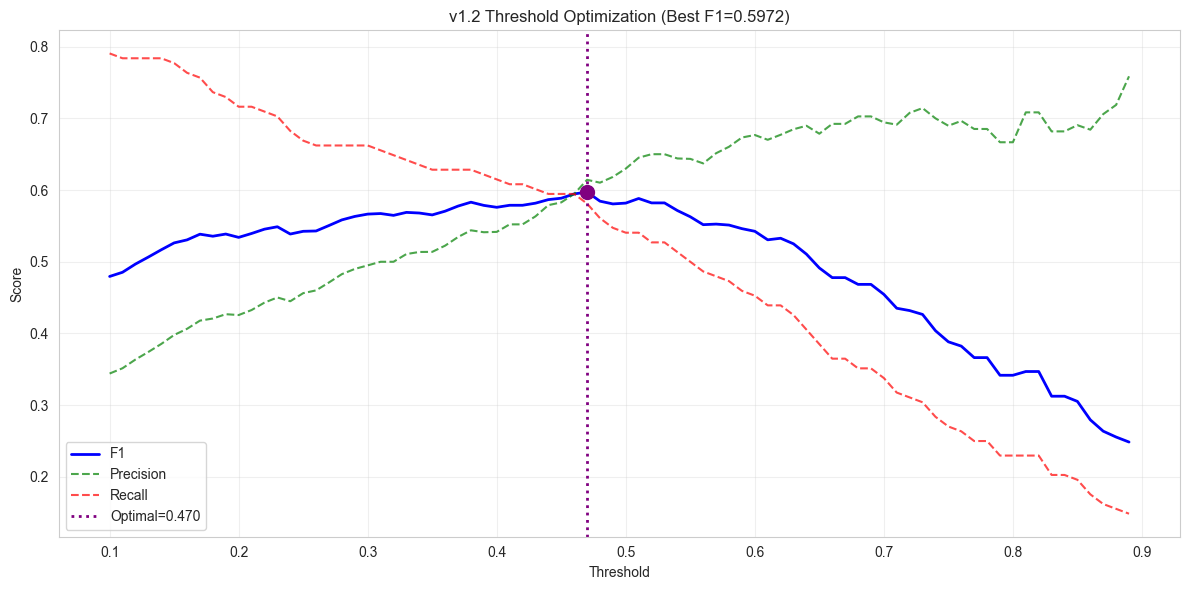

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(thresholds, f1_scores, 'b-', linewidth=2, label='F1')
ax.plot(thresholds, precision_scores, 'g--', alpha=0.7, label='Precision')
ax.plot(thresholds, recall_scores, 'r--', alpha=0.7, label='Recall')
ax.axvline(best_threshold, color='purple', linestyle=':', linewidth=2, 
           label=f'Optimal={best_threshold:.3f}')
ax.scatter([best_threshold], [best_f1_optimized], color='purple', s=100, zorder=5)
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title(f'v1.2 Threshold Optimization (Best F1={best_f1_optimized:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=150)
plt.show()

## Ma trận Nhầm lẫn


Classification Report:
              precision    recall  f1-score   support

     Non-TDE       0.98      0.98      0.98      2895
         TDE       0.61      0.58      0.60       148

    accuracy                           0.96      3043
   macro avg       0.80      0.78      0.79      3043
weighted avg       0.96      0.96      0.96      3043



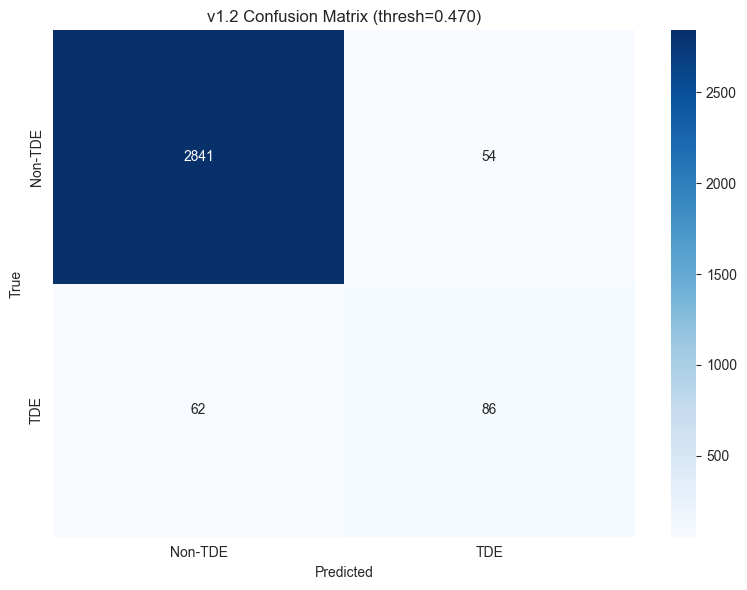

In [11]:
best_preds = (cv_proba >= best_threshold).astype(int)
cm = confusion_matrix(y, best_preds)

print("\nClassification Report:")
print(classification_report(y, best_preds, target_names=['Non-TDE', 'TDE']))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'])
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
ax.set_title(f'v1.2 Confusion Matrix (thresh={best_threshold:.3f})')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

## Tầm quan trọng của Features


Top 30 Features:
            feature  importance
         r_flux_p25          64
       i_decay_rate          61
                  Z          58
     peak_delay_g_r          58
   peak_time_spread          54
       g_decay_rate          47
     g_det_duration          45
     r_det_duration          43
        g_rise_time          39
        r_flux_skew          39
        r_rise_rate          38
       z_decay_rate          37
detection_time_span          37
    r_flux_kurtosis          35
     color_peak_r_i          33
     u_cadence_mean          32
        u_time_span          32
               r_cv          31
        i_flux_skew          29
   mean_variability          29
    i_peak_time_rel          28
          u_snr_max          27
        r_rise_time          26
          i_err_std          26
       r_decay_rate          26
          u_err_std          26
        i_time_span          25
         r_flux_p10          25
     i_det_duration          25
  r_frac_above_mean   

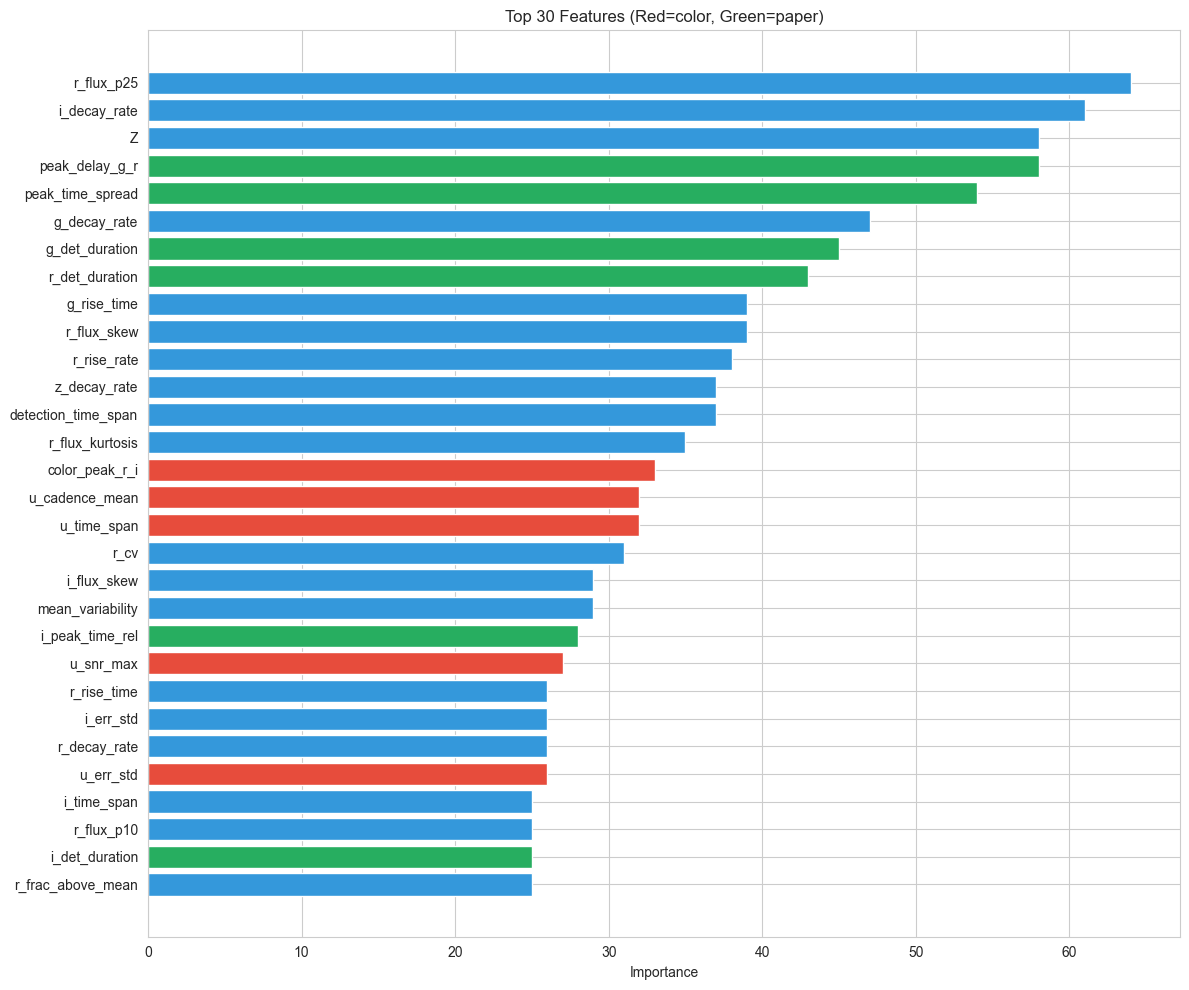

In [12]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 30 Features:")
print(feature_importance.head(30).to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 10))
top_n = 30
top_features = feature_importance.head(top_n)

def get_color(f):
    if 'color' in f or 'blue' in f or f.startswith('u_'):
        return '#e74c3c'
    elif 'some_color' in f or 'peak' in f or 'duration' in f:
        return '#27ae60'
    else:
        return '#3498db'

colors = [get_color(f) for f in top_features['feature']]
ax.barh(range(len(top_features)), top_features['importance'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n} Features (Red=color, Green=paper)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

## Lưu Model

In [13]:
joblib.dump(final_model, 'lgb_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

model_info = {
    'best_threshold': best_threshold,
    'best_f1': best_f1_optimized,
    'best_precision': best_precision,
    'best_recall': best_recall,
    'roc_auc': roc_auc_score(y, cv_proba),
    'scale_pos_weight': scale_pos_weight,
    'feature_cols': feature_cols,
    'best_params': best_params,
    'version': 'v1.2'
}
joblib.dump(model_info, 'model_info.joblib')

feature_importance.to_csv('feature_importance.csv', index=False)
pd.DataFrame(results).to_csv('hyperparam_search_results.csv', index=False)

print("\n" + "="*60)
print("v1.2 MODEL TRAINING COMPLETE")
print("="*60)
print(f"\nCV F1: {best_f1_optimized:.4f}")
print(f"Threshold: {best_threshold:.3f}")
print(f"\nModel: depth={best_params['max_depth']}, leaves={best_params['num_leaves']}")
print(f"\nFiles saved. Next: 03_prediction_submission.ipynb")


v1.2 MODEL TRAINING COMPLETE

CV F1: 0.5972
Threshold: 0.470

Model: depth=5, leaves=15

Files saved. Next: 03_prediction_submission.ipynb
